# Loading and visualization of dips

``` 
A contrario dip picking for borehole imaging.
J. Costes, G. Facciolo, R. Grompone von Gioi, J. Kherroubi, E. Meinhardt-Llopis, and J.-M. Morel. 
SEG Geophysics, 2021. https://cmla.github.io/dip-picker/
```

In [29]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt

load borehole image `file_image`, the dip annotations `file_dip` and the automatic detections `autodips`

In [39]:

## wellog C
file_image = './48_19a-C2_Ream Up 3_3B.csv'
file_dip = './48_19a-C2_DipJK.csv'
autodips = pd.read_csv('48_19a-C2_Ream Up 3_3B.tif_out_dips_c4_ms.txt',sep=' ')

# reference dips from the paper
#autodips = pd.read_csv('out_dips_c2_ms_sigma1_ref100.txt',sep=' ')
maxNFA=30
maxoctave=4



read the manually annotated dips

In [40]:
## read manual annotatios

df_image = pd.read_csv(file_image)
image_depth = df_image.values
image_depths_ft_initial = image_depth[1:, 2]
#print(image_depths_ft_initial[0:20])
image_depths_ft_initial = image_depths_ft_initial.astype(float)

image_initial = image_depth[1:, 3]
#print(image_initial[0:20])
image_initial = image_initial.astype(float)

df_dip = pd.read_csv(file_dip)
df_dip = df_dip.drop_duplicates() 

dip_depths_ft = df_dip['TDEP'].values
#print(dip_depths_ft[1:20])
dip_depths_ft = dip_depths_ft[1:].astype(float)

dip_calipers_in = df_dip['AvgCali'].values
#print(dip_calipers_in[1:20])
dip_calipers_in = dip_calipers_in[1:].astype(float)

try:
    dip_inclinos_deg = df_dip['RES_BD_IMG_Dip_APP'].values
except KeyError: 
    dip_inclinos_deg = df_dip['RES_BD_IMG_DipPiking_JK_APP'].values#print(dip_inclinos_deg[1:20])
dip_inclinos_deg = dip_inclinos_deg[1:].astype(float)

dip_azs_deg = df_dip['RES_BD_IMG_Azimuth'].values
#print(dip_azs_deg[1:20])
dip_azs_deg = dip_azs_deg[1:].astype(float)


## determine parameters 

num_columns = np.sum(image_depths_ft_initial == image_depths_ft_initial[0])
num_rows = int(len(image_depths_ft_initial)/num_columns+0.5)
image = np.reshape(image_initial, (num_rows, num_columns), order='C')
image_depths_ft = image_depths_ft_initial[0:len(image_depths_ft_initial):num_columns]
step_depth_ft = image_depths_ft[1] - image_depths_ft[0]
## assume a constant caliper
dip_caliper_in = dip_calipers_in[0]/12./step_depth_ft

print('Number of rows: ' + str(num_rows))
print('Number of columns: ' + str(num_columns))

Number of rows: 6001
Number of columns: 56


/var/folders/9n/md45pd311bz4ln5k_zdt2tph0000gn/T/ipykernel_65868/606177477.py:3: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_image = pd.read_csv(file_image)


read and filter the automatic dip detections also perform some transformations

In [41]:

#### READ the automatic dips 


autodips = autodips.sort_values('depth')
dip_depths_auto = autodips['depth'].values
dip_octave_auto = autodips['octave'].values
dip_depths_auto_ft = image_depths_ft[0] + dip_depths_auto*step_depth_ft
dip_a_auto = autodips['phi1'].values 
dip_b_auto = autodips['phi2'].values 


## select the automatic dips based on their NFA
dip_depths_nfa = np.where( (autodips['nfa'].values < maxNFA)  &  
                          (dip_depths_auto_ft < dip_depths_ft[-1])   &
                          (dip_depths_auto_ft > dip_depths_ft[0]) &
                          (dip_octave_auto <= maxoctave )
                         ) 

dip_depths_auto = dip_depths_auto[dip_depths_nfa] 
dip_depths_auto_ft = dip_depths_auto_ft[dip_depths_nfa] 
dip_a_auto = dip_a_auto[dip_depths_nfa]
dip_b_auto = dip_b_auto[dip_depths_nfa]


#Convert to az and incl
dip_az_phi_auto = np.mod( np.arctan2(dip_b_auto,dip_a_auto) , 2*np.pi)
r= np.sqrt(dip_a_auto**2 + dip_b_auto**2)
dip_inclin_auto = np.arctan( r  * num_columns/np.pi / (0.5*dip_caliper_in)  )


print("detected dips: ", len(dip_depths_auto_ft))




detected dips:  196


### display the annotaed dip at index `index_dip`

Dip depth: 13384.4330844067
index depht local: 256.323376


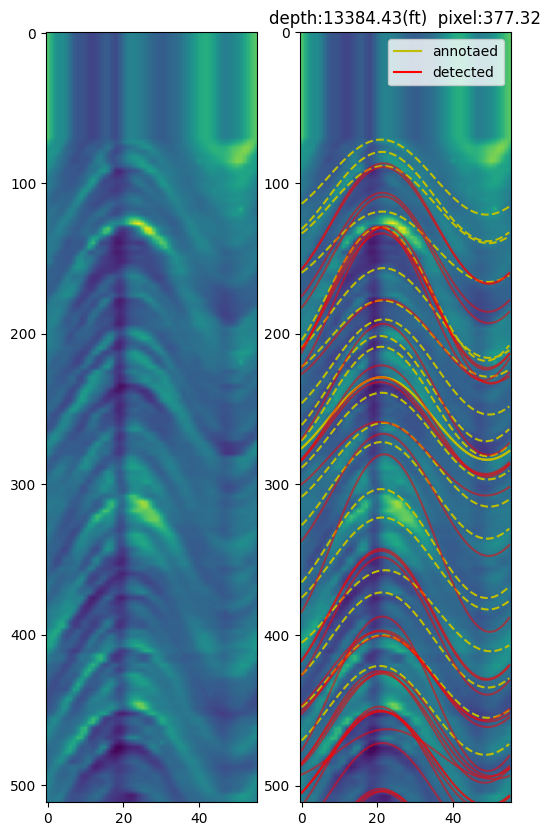

In [50]:
## change these parameters 
index_dip = 10   # index of the dip to be shown
half_rows = 256  # 1/2 of the chunk of image to be displayed


#### 

dip_depth = dip_depths_ft[index_dip]
dip_inclino = dip_inclinos_deg[index_dip]*math.pi/180
dip_az = dip_azs_deg[index_dip]*math.pi/180
dip_caliper_index = dip_calipers_in[index_dip]/12./step_depth_ft
print('Dip depth: ' + str(dip_depth))
index_dip_depth = (dip_depth-image_depths_ft[0])/step_depth_ft

# store the  depth of the central dip
main_dip_depth = dip_depth   

# chunk of image to be displayed
#half_rows = 128
half_rows = half_rows
index_depth_start = int(index_dip_depth-half_rows)
index_depth_end = int(index_dip_depth+half_rows)

# visualization range
image_chunk = image[index_depth_start:index_depth_end, :]
data = image_chunk.flatten()
image_chunk_display = (image_chunk-np.min(data))/(np.max(data)-np.min(data))


## display the dip  
dip_columns = np.arange(num_columns)
dip_columns_angle = dip_columns*2*math.pi/num_columns

index_dip_depth_local = (dip_depth-image_depths_ft[index_depth_start])/step_depth_ft
print('index depht local: %f'%index_dip_depth_local)
dip_rows = index_dip_depth_local + 0.5*dip_caliper_index*np.tan(dip_inclino)*np.cos(dip_columns_angle-dip_az)


# display images
fig, axes = plt.subplots(1, 2, figsize=(6,10))
axes[0].imshow(image_chunk_display, aspect='auto')
axes[1].imshow(image_chunk_display, aspect='auto')
axes[1].plot(dip_columns, dip_rows, 'y')


## display the  +- 10 dips around the central one
for ii in range( max(0,index_dip-10), min(index_dip+10, len(dip_depths_ft)-1 ) ):
    dip_depth = dip_depths_ft[ii]
    dip_inclino = dip_inclinos_deg[ii]*math.pi/180
    dip_az = dip_azs_deg[ii]*math.pi/180
    dip_caliper_index = dip_calipers_in[ii]/12./step_depth_ft
    #print('Dip depth: ' + str(dip_depth))
    #index_dip_depth = (dip_depth-image_depths_ft[0])/step_depth_ft


    index_dip_depth_local = (dip_depth-image_depths_ft[index_depth_start])/step_depth_ft
    #print(index_dip_depth_local)
    dip_rows = index_dip_depth_local + (
            0.5*dip_caliper_index*np.tan(dip_inclino)*np.cos(dip_columns_angle-dip_az))

    # plot the index_dip and its neighbors 
    plt.ylim(half_rows*2-1,0)
    if ii == index_dip :         
        axes[1].plot(dip_columns, dip_rows, 'y')
    else:
        axes[1].plot(dip_columns, dip_rows, 'y--')

        
## display dips  +- 100 ft around the central one
for ii in np.where( ( dip_depths_auto_ft < main_dip_depth +100) & ( dip_depths_auto_ft > main_dip_depth -100) )[0]:
    dip_depth = dip_depths_auto_ft[ii]

    index_dip_depth_local = (dip_depth-image_depths_ft[index_depth_start])/step_depth_ft

    # use the other representation
    dip_rows = index_dip_depth_local +  (
        0.5*dip_caliper_index*np.tan(dip_inclin_auto[ii])* np.cos(dip_columns_angle-dip_az_phi_auto[ii]))

    plt.ylim(half_rows*2-1,0)
    axes[1].plot(dip_columns, dip_rows, color='r',alpha=.5)

    
    
plt.title("depth:%.2f(ft)  pixel:%.2f"%(main_dip_depth, index_dip_depth) )    
axes[1].plot([], [], 'y', label='annotaed')
axes[1].plot([], [], 'r', label='detected')
axes[1].legend()
